In [1]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [31]:
bs_loc = np.array([[100,100], [900,900], [100, 900], [900, 100]])
bs_power = np.array([40., 40., 40., 40.]) #40 watts each
fc = 2.6 #2.6 GHz
bandwidth = 1e7 #10 MHz
temp = 40 + 273.15 # 40 celsius in kelvin
boltz = 1.381e-23
epsilon = 1e-7

class Environment():
    def __init__(self, bs_loc, bs_power, max_power, min_power, n_actions, grid_width, grid_height, n_nearest):
        self.bs_loc = bs_loc
        self.bs_power = bs_power
        self.electricity = np.zeros_like(bs_power)
        self.max_power = max_power # in watt
        self.min_power = min_power
        self.n_actions = n_actions
        self.grid_width = grid_width
        self.grid_height = grid_height
        self.points = np.mgrid[0:grid_width, 0:grid_height]
        self.points = np.stack(self.points, axis=-1)
        self.powers = self.power_grid(self.bs_loc, self.bs_power, self.points)
        self.bit_rate = self.bit_rate_from_grid()
        self.reward = self.get_reward()
        self.actions = self.watt_to_dbm(np.linspace(min_power, max_power, n_actions))
        self.n_nearest = min(n_nearest, bs_power.shape[0])
        self.n_bs = bs_power.shape[0]
        
    def get_input_dim(self):
        return self.n_nearest*3 # after adding has electricity attrib 3 will be changed to 4
    
    def get_output_dim(self):
        return self.n_actions
    
    def make_action(self, bs_index, action):
        state = self.get_state(bs_index) 
        self.bs_power[bs_index] = self.actions[action]
        self.powers = self.power_grid(self.bs_loc, self.bs_power, self.points)
        self.bit_rate = self.bit_rate_from_grid()
        next_state = self.get_state(bs_index)
        reward = self.get_reward()
        return state, action, next_state, reward
        
    def watt_to_dbm(self, watt):
        return 10*np.log10(1000*watt)

    def dbm_to_watt(self, dbm):
        return np.power(10, dbm/10)/1000

    def path_loss(self, distance, frequency=fc):
    #     return 36.7*np.log10(distance) + 47.7 + 26*np.log10(frequency)
        return 35*np.log10(distance) + 35.7

    def power_grid(self, bs_loc, bs_power, points):
        powers = []
        for loc, power in zip(bs_loc, bs_power):
            distance = np.linalg.norm(loc - points+epsilon, axis=-1)
            powers.append(power - self.path_loss(distance))
        return np.stack(powers, axis=-1)

    def get_bit_rate_sinr(self, signal, interference, bandwidth=bandwidth, temp=temp):
        return bandwidth*np.log10(1+ (signal/(interference + temp*boltz*bandwidth)))
    
    def bit_rate_from_grid(self):
        max_power = self.dbm_to_watt(self.powers.max(axis=-1))
        interference_power = self.dbm_to_watt(self.powers).sum(axis=-1) - max_power
        return self.get_bit_rate_sinr(max_power, interference_power)

    def bit_rate_cost_function(self, b_rate):
        total_points = 1
        for i in b_rate.shape:
            total_points *= i

        under_1mb = b_rate<(1024**2)*8
        under_1mb = under_1mb.sum()
        min_speed = b_rate.min()/(1024*1024*8) #1MB
        return 10*under_1mb/total_points + 1/(min_speed+epsilon)

    def get_reward(self):
        return 10 - self.bit_rate_cost_function(self.bit_rate) - np.inner(self.electricity, self.dbm_to_watt(self.bs_power))
    
    def get_state(self, bs_index):
        x,y = self.bs_loc[bs_index]
        powers = self.powers[np.round(x),np.round(y),:].reshape(-1)
        indecies = np.argsort(powers)[::-1][:self.n_nearest]
        bs_index_posistion = np.where(indecies == bs_index)[0]
        if bs_index_posistion.size > 0:
            indecies = np.delete(indecies, bs_index_posistion)
            indecies = indecies[:self.n_nearest]
        else:
            indecies = indecies[:self.n_nearest-1]
        bs_power = powers[bs_index]
        state = np.array([powers[bs_index], 0, 0])
        nearest_powers = powers[np.array(indecies)]
        diff =  self.bs_loc[np.array(indecies)] - self.bs_loc[bs_index]
        nearest_distances = np.linalg.norm(diff, axis=-1)
        nearest_angles = np.arctan2(diff[:,1].reshape(-1), diff[:,0].reshape(-1))
        
        return np.hstack((state, np.stack([nearest_powers, 
                                           nearest_distances, nearest_angles], axis=-1).reshape(-1)))
    
    def plot_bit_rate(self):
        plt.contourf(self.points[:,:,0], self.points[:,:,1], self.bit_rate, 100, cmap = plt.cm.jet)
        
    def plot_log_bit_rate(self):
        plt.contourf(self.points[:,:,0], self.points[:,:,1], self.bit_rate, 100, cmap = plt.cm.jet)
        
    def plot_power_grid(self):
        plt.contourf(self.points[:,:,0], self.points[:,:,1], self.bit_rate, 100, cmap = plt.cm.jet)
        
    def plot_log_power_grid(self):
        plt.contourf(self.points[:,:,0], self.points[:,:,1], self.bit_rate, 100, cmap = plt.cm.jet)

In [32]:
class DQN(nn.Module): # ready
    def __init__(self, n_inputs, n_actions):
        nn.Module.__init__(self)
        self.fc1 = nn.Linear(in_features=n_inputs, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=n_actions)

    def forward(self, t):
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

In [33]:
Experience = namedtuple(
    "Experience", ("state", "action", "next_state", "reward")) # ready

In [34]:
class ReplayMemory(): # ready
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [35]:
class EpsilonGreedyStrategy(): # ready
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * np.exp(-1. * current_step * self.decay)

In [36]:
class Agent():
    def __init__(self, strategy, num_actions):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions

    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action])
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1)

In [37]:
class QValues():
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    @staticmethod
    def get_next(target_net, next_states):
        values = target_net(next_states).max(dim=1)[0].detach()
        return values

In [38]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title("Training...")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    plt.plot(values)

    moving_avg = get_moving_avg(moving_avg_period, values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode", len(values), "\n", moving_avg_period,
          "episode moving avg:", moving_avg[-1])
#     if is_ipython:
#         display.clear_output(wait=True)

In [39]:
def get_moving_avg(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(
            dim=1).flatten(start_dim=0)
    else:
        moving_avg = torch.zeros_like(values)
    return moving_avg.numpy()

In [40]:
def extract_tensors(exps):
    batch = Experience(*zip(*exps))
    
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.next_state)
    t4 = torch.cat(batch.reward)

    return (t1, t2, t3, t4)

In [41]:
batch_size = 256
gamma = 0.7
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 1000
lr = 0.001
num_episodes = 5000

env = Environment(bs_loc, bs_power, 10, 0, 9, 1000, 1000, 4)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, env.get_output_dim())
memory = ReplayMemory(memory_size)

policy_net = DQN(env.get_input_dim(), env.get_output_dim())
target_net = DQN(env.get_input_dim(), env.get_output_dim())
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

<ipython-input-31-6b7e6bff6962>:44: RuntimeWarning: divide by zero encountered in log10
  return 10*np.log10(1000*watt)


In [42]:
rewards_history = []
for episode in range(num_episodes):
    timer = time.time()
    print("\n\nEPISODE:", episode+1)
    
    for i in range(env.n_bs):
        state = torch.tensor(env.get_state(i), dtype=torch.float).unsqueeze(0)

        action = agent.select_action(state, policy_net)
        _, action, next_state, reward = env.make_action(i, action)
        
        rewards_history.append(reward)

        reward = torch.tensor([reward], dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(0)
        memory.push(Experience(state, action, next_state, reward))
        state = next_state

        if memory.can_provide_sample(batch_size):
            exps = memory.sample(batch_size)
            states, actions, next_states, rewards = extract_tensors(exps)
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            optimizer.zero_grad()
            loss = F.smooth_l1_loss(
                current_q_values, target_q_values.unsqueeze(1))
            loss.backward()
            optimizer.step()

        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        print("EPISODE DONE IN {} SECONDS, reward {}, action {}".format(time.time() - timer, reward[0], action[0]))



EPISODE: 1
EPISODE DONE IN 0.5580413341522217 SECONDS, reward -0.4617145359516144, action 1
EPISODE DONE IN 1.1043682098388672 SECONDS, reward -0.22439336776733398, action 6
EPISODE DONE IN 1.6632885932922363 SECONDS, reward -1.5816013813018799, action 1
EPISODE DONE IN 2.2177176475524902 SECONDS, reward -2.122255563735962, action 6


EPISODE: 2
EPISODE DONE IN 0.5586962699890137 SECONDS, reward -0.5947555303573608, action 6
EPISODE DONE IN 1.1116735935211182 SECONDS, reward -0.7096627354621887, action 5
EPISODE DONE IN 1.669276475906372 SECONDS, reward -1.6588608026504517, action 5
EPISODE DONE IN 2.2215049266815186 SECONDS, reward -1.0727852582931519, action 4


EPISODE: 3
EPISODE DONE IN 0.5566411018371582 SECONDS, reward -1.0577448606491089, action 2
EPISODE DONE IN 1.109679937362671 SECONDS, reward -1.0577448606491089, action 5
EPISODE DONE IN 1.66756010055542 SECONDS, reward -0.8664935827255249, action 6
EPISODE DONE IN 2.2203614711761475 SECONDS, reward -0.8664935827255249, ac

EPISODE DONE IN 1.698732614517212 SECONDS, reward -0.7514554858207703, action 8
EPISODE DONE IN 2.2588257789611816 SECONDS, reward -1.4375109672546387, action 4


EPISODE: 26
EPISODE DONE IN 0.5766568183898926 SECONDS, reward -0.4721514582633972, action 1
EPISODE DONE IN 1.138720989227295 SECONDS, reward 0.24485132098197937, action 1
EPISODE DONE IN 1.7055912017822266 SECONDS, reward 0.1381617933511734, action 6
EPISODE DONE IN 2.2674624919891357 SECONDS, reward -0.45567840337753296, action 1


EPISODE: 27
EPISODE DONE IN 0.5676157474517822 SECONDS, reward -1.7956104278564453, action 5
EPISODE DONE IN 1.1155035495758057 SECONDS, reward -0.6026293039321899, action 0
EPISODE DONE IN 1.6604301929473877 SECONDS, reward -1.2021427154541016, action 4
EPISODE DONE IN 2.2025091648101807 SECONDS, reward -0.2771685719490051, action 5


EPISODE: 28
EPISODE DONE IN 0.5529069900512695 SECONDS, reward -0.3240374028682709, action 6
EPISODE DONE IN 1.11332368850708 SECONDS, reward -1.3130933046340942,

EPISODE DONE IN 0.5630519390106201 SECONDS, reward -0.08716513961553574, action 7
EPISODE DONE IN 1.1109349727630615 SECONDS, reward -0.08716513961553574, action 6
EPISODE DONE IN 1.6647639274597168 SECONDS, reward -0.16384343802928925, action 8
EPISODE DONE IN 2.2206485271453857 SECONDS, reward -0.16384343802928925, action 0


EPISODE: 51
EPISODE DONE IN 0.5499114990234375 SECONDS, reward 0.20716089010238647, action 0
EPISODE DONE IN 1.0611662864685059 SECONDS, reward -0.44022637605667114, action 2
EPISODE DONE IN 1.5791497230529785 SECONDS, reward -1.1282588243484497, action 7
EPISODE DONE IN 2.1235320568084717 SECONDS, reward -1.1282588243484497, action 0


EPISODE: 52
EPISODE DONE IN 0.5396504402160645 SECONDS, reward -2.816877841949463, action 2
EPISODE DONE IN 1.084263563156128 SECONDS, reward -2.816877841949463, action 2
EPISODE DONE IN 1.6234283447265625 SECONDS, reward -2.050957202911377, action 3
EPISODE DONE IN 2.193619728088379 SECONDS, reward -0.3176479935646057, action 6


EPISODE DONE IN 1.627319574356079 SECONDS, reward 1.8937617540359497, action 0
EPISODE DONE IN 2.128897190093994 SECONDS, reward 1.8937617540359497, action 0


EPISODE: 75
EPISODE DONE IN 0.5028238296508789 SECONDS, reward 1.8937617540359497, action 0
EPISODE DONE IN 1.0159635543823242 SECONDS, reward -1.3662217855453491, action 4
EPISODE DONE IN 1.5691227912902832 SECONDS, reward -1.1906092166900635, action 3
EPISODE DONE IN 2.0925381183624268 SECONDS, reward -1.1906092166900635, action 0


EPISODE: 76
EPISODE DONE IN 0.548820972442627 SECONDS, reward -1.1906092166900635, action 0
EPISODE DONE IN 1.0993123054504395 SECONDS, reward -1.1906092166900635, action 4
EPISODE DONE IN 1.6380901336669922 SECONDS, reward -0.3883856236934662, action 6
EPISODE DONE IN 2.1847119331359863 SECONDS, reward -0.5347522497177124, action 1


EPISODE: 77
EPISODE DONE IN 0.6006107330322266 SECONDS, reward -1.0645132064819336, action 5
EPISODE DONE IN 1.206606388092041 SECONDS, reward -0.8552821278572083, ac

EPISODE DONE IN 0.5247294902801514 SECONDS, reward -17.0012149810791, action 0
EPISODE DONE IN 1.0301969051361084 SECONDS, reward -17.0012149810791, action 0
EPISODE DONE IN 1.458120346069336 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 1.8885610103607178 SECONDS, reward -10000000.0, action 0


EPISODE: 100
EPISODE DONE IN 0.5233523845672607 SECONDS, reward -7.049383640289307, action 2
EPISODE DONE IN 1.0587458610534668 SECONDS, reward 0.939697265625, action 5
EPISODE DONE IN 1.6075172424316406 SECONDS, reward -0.4351504445075989, action 4
EPISODE DONE IN 2.187483549118042 SECONDS, reward -0.5930805802345276, action 8


EPISODE: 101
EPISODE DONE IN 0.6096906661987305 SECONDS, reward -0.5930805802345276, action 2
EPISODE DONE IN 1.190150260925293 SECONDS, reward -0.020508287474513054, action 2
EPISODE DONE IN 1.734253168106079 SECONDS, reward -2.0379323959350586, action 0
EPISODE DONE IN 2.306128978729248 SECONDS, reward -1.6952961683273315, action 2


EPISODE: 102
EPISODE DONE

EPISODE DONE IN 1.6384754180908203 SECONDS, reward -0.010230560787022114, action 7
EPISODE DONE IN 2.1684532165527344 SECONDS, reward 0.01561641599982977, action 2


EPISODE: 124
EPISODE DONE IN 0.5569968223571777 SECONDS, reward -0.4655759930610657, action 8
EPISODE DONE IN 1.1690244674682617 SECONDS, reward -1.209702491760254, action 3
EPISODE DONE IN 1.750006914138794 SECONDS, reward -0.14442338049411774, action 2
EPISODE DONE IN 2.305293560028076 SECONDS, reward -0.5795155763626099, action 4


EPISODE: 125
EPISODE DONE IN 0.5832254886627197 SECONDS, reward -0.4959698021411896, action 0
EPISODE DONE IN 1.1269052028656006 SECONDS, reward 0.5345990061759949, action 0
EPISODE DONE IN 1.619159460067749 SECONDS, reward -1.3503496646881104, action 0
EPISODE DONE IN 2.104076385498047 SECONDS, reward 1.074416160583496, action 6


EPISODE: 126
EPISODE DONE IN 0.5586953163146973 SECONDS, reward -0.705272912979126, action 3
EPISODE DONE IN 1.0956060886383057 SECONDS, reward -0.705272912979126,

EPISODE DONE IN 0.5610344409942627 SECONDS, reward 0.5345990061759949, action 0
EPISODE DONE IN 1.1228222846984863 SECONDS, reward 0.5345990061759949, action 0
EPISODE DONE IN 1.631404161453247 SECONDS, reward -7.0729827880859375, action 0
EPISODE DONE IN 2.061154842376709 SECONDS, reward -10000000.0, action 0


EPISODE: 149
EPISODE DONE IN 0.4466991424560547 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 0.9713442325592041 SECONDS, reward -1.3662217855453491, action 4
EPISODE DONE IN 1.4794731140136719 SECONDS, reward -1.3662217855453491, action 0
EPISODE DONE IN 2.002321243286133 SECONDS, reward -0.23154957592487335, action 7


EPISODE: 150
EPISODE DONE IN 0.5377120971679688 SECONDS, reward -0.23154957592487335, action 0
EPISODE DONE IN 1.08659029006958 SECONDS, reward -0.04206221178174019, action 5
EPISODE DONE IN 1.6427812576293945 SECONDS, reward 0.0038442194927483797, action 7
EPISODE DONE IN 2.17647647857666 SECONDS, reward -0.4915789067745209, action 1


EPISODE: 151
EPI

EPISODE DONE IN 1.9020564556121826 SECONDS, reward -10000000.0, action 0


EPISODE: 173
EPISODE DONE IN 0.5118062496185303 SECONDS, reward -1.3344745635986328, action 4
EPISODE DONE IN 0.9915730953216553 SECONDS, reward -1.3344745635986328, action 0
EPISODE DONE IN 1.478712797164917 SECONDS, reward -1.3344745635986328, action 0
EPISODE DONE IN 1.9564809799194336 SECONDS, reward -1.3344745635986328, action 0


EPISODE: 174
EPISODE DONE IN 0.45529842376708984 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 0.973543643951416 SECONDS, reward 1.8937617540359497, action 7
EPISODE DONE IN 1.5344161987304688 SECONDS, reward -1.1390821933746338, action 2
EPISODE DONE IN 2.1920855045318604 SECONDS, reward -1.143761396408081, action 4


EPISODE: 175
EPISODE DONE IN 0.576850175857544 SECONDS, reward -0.1002868041396141, action 8
EPISODE DONE IN 1.1196293830871582 SECONDS, reward -1.3601070642471313, action 0
EPISODE DONE IN 1.7125554084777832 SECONDS, reward -0.22436289489269257, action 8
EP

EPISODE DONE IN 1.17685866355896 SECONDS, reward -1.0650131702423096, action 6
EPISODE DONE IN 1.7549738883972168 SECONDS, reward -1.0650131702423096, action 5
EPISODE DONE IN 2.34547758102417 SECONDS, reward -0.6068392992019653, action 0


EPISODE: 198
EPISODE DONE IN 0.5793719291687012 SECONDS, reward -0.14849433302879333, action 5
EPISODE DONE IN 1.1045212745666504 SECONDS, reward -0.34341686964035034, action 0
EPISODE DONE IN 1.6603574752807617 SECONDS, reward 0.04991356283426285, action 0
EPISODE DONE IN 2.226088047027588 SECONDS, reward -1.6203471422195435, action 2


EPISODE: 199
EPISODE DONE IN 0.5630619525909424 SECONDS, reward -2.2807090282440186, action 3
EPISODE DONE IN 1.1146337985992432 SECONDS, reward -0.8736726641654968, action 1
EPISODE DONE IN 1.7053802013397217 SECONDS, reward -0.8736726641654968, action 0
EPISODE DONE IN 2.2968764305114746 SECONDS, reward -1.3457903861999512, action 8


EPISODE: 200
EPISODE DONE IN 0.5584537982940674 SECONDS, reward -0.5880107283592

EPISODE DONE IN 0.5963196754455566 SECONDS, reward 0.20946721732616425, action 0
EPISODE DONE IN 1.119208574295044 SECONDS, reward 1.6599963903427124, action 0
EPISODE DONE IN 1.6198222637176514 SECONDS, reward 2.6046342849731445, action 0
EPISODE DONE IN 2.145961284637451 SECONDS, reward -1.3503496646881104, action 4


EPISODE: 223
EPISODE DONE IN 0.5315957069396973 SECONDS, reward -1.3503496646881104, action 0
EPISODE DONE IN 1.026911735534668 SECONDS, reward -1.3503496646881104, action 0
EPISODE DONE IN 1.5532655715942383 SECONDS, reward 0.6113405227661133, action 3
EPISODE DONE IN 2.110891103744507 SECONDS, reward 1.485865592956543, action 7


EPISODE: 224
EPISODE DONE IN 0.5837290287017822 SECONDS, reward 0.0042036124505102634, action 2
EPISODE DONE IN 1.155113935470581 SECONDS, reward -0.46047618985176086, action 3
EPISODE DONE IN 1.7341053485870361 SECONDS, reward -1.888031244277954, action 0
EPISODE DONE IN 2.289818048477173 SECONDS, reward -0.07651835680007935, action 0


EPIS

EPISODE DONE IN 0.5797836780548096 SECONDS, reward 1.0881047248840332, action 6
EPISODE DONE IN 1.1528840065002441 SECONDS, reward 1.0881047248840332, action 0
EPISODE DONE IN 1.72847318649292 SECONDS, reward 1.0881047248840332, action 0
EPISODE DONE IN 2.336498737335205 SECONDS, reward -1.4812191724777222, action 2


EPISODE: 248
EPISODE DONE IN 0.6114358901977539 SECONDS, reward -0.43096116185188293, action 8
EPISODE DONE IN 1.2482919692993164 SECONDS, reward -0.009260287508368492, action 2
EPISODE DONE IN 1.8889176845550537 SECONDS, reward -0.009260287508368492, action 0
EPISODE DONE IN 2.48856258392334 SECONDS, reward 1.7100001573562622, action 0


EPISODE: 249
EPISODE DONE IN 0.5764429569244385 SECONDS, reward -7.09658670425415, action 0
EPISODE DONE IN 1.1509864330291748 SECONDS, reward 1.0607329607009888, action 6
EPISODE DONE IN 1.7268338203430176 SECONDS, reward 1.0607329607009888, action 0
EPISODE DONE IN 2.3265621662139893 SECONDS, reward 1.0607329607009888, action 0


EPISO

EPISODE DONE IN 1.0839309692382812 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 1.671722650527954 SECONDS, reward 1.90692138671875, action 7
EPISODE DONE IN 2.273486852645874 SECONDS, reward 1.90692138671875, action 0


EPISODE: 273
EPISODE DONE IN 0.5874209403991699 SECONDS, reward 1.90692138671875, action 0
EPISODE DONE IN 1.1871321201324463 SECONDS, reward 1.90692138671875, action 0
EPISODE DONE IN 1.732513666152954 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 2.245807647705078 SECONDS, reward -10000000.0, action 0


EPISODE: 274
EPISODE DONE IN 0.5081555843353271 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 1.095921277999878 SECONDS, reward -1.3662217855453491, action 4
EPISODE DONE IN 1.673543930053711 SECONDS, reward -1.3662217855453491, action 0
EPISODE DONE IN 2.2828822135925293 SECONDS, reward -1.3662217855453491, action 0


EPISODE: 275
EPISODE DONE IN 0.6240212917327881 SECONDS, reward -1.3662217855453491, action 0
EPISODE DONE IN 1.135414838790893

EPISODE DONE IN 1.233407974243164 SECONDS, reward -3.4047372341156006, action 0
EPISODE DONE IN 1.7914283275604248 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 2.405158519744873 SECONDS, reward -7.0729827880859375, action 2


EPISODE: 298
EPISODE DONE IN 0.5934069156646729 SECONDS, reward -7.0729827880859375, action 0
EPISODE DONE IN 1.1691758632659912 SECONDS, reward -7.0729827880859375, action 0
EPISODE DONE IN 1.7935888767242432 SECONDS, reward 1.49413001537323, action 7
EPISODE DONE IN 2.3929927349090576 SECONDS, reward 1.90692138671875, action 0


EPISODE: 299
EPISODE DONE IN 0.6016314029693604 SECONDS, reward 1.90692138671875, action 0
EPISODE DONE IN 1.2174761295318604 SECONDS, reward 1.90692138671875, action 0
EPISODE DONE IN 1.7430806159973145 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 2.3288495540618896 SECONDS, reward 2.6046342849731445, action 8


EPISODE: 300
EPISODE DONE IN 0.619732141494751 SECONDS, reward 2.6046342849731445, action 0
EPISODE DONE IN 

KeyboardInterrupt: 

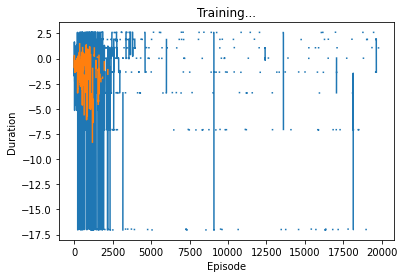

Episode 20000 
 10 episode moving avg: -inf


In [14]:
plot(rewards_history, 10)

In [19]:
env.get_reward()

<ipython-input-2-239b063bd2c2>:74: RuntimeWarning: divide by zero encountered in double_scalars
  return 10*under_1mb/total_points + 1/min_speed


-inf

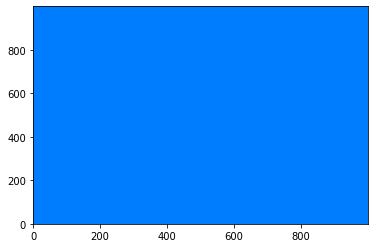

In [16]:
plt.contourf(env.points[:,:,0], env.points[:,:,1], env.bit_rate, 100, cmap = plt.cm.jet)

In [17]:
print(env.bs_power)

[-inf -inf -inf -inf]
